# Model import using the Petab format

In this notebook, we illustrate how to use [pyPESTO](https://github.com/icb-dcm/pypesto.git) together with [PEtab](https://github.com/petab-dev/petab.git) and [AMICI](https://github.com/icb-dcm/amici.git). We employ models from the [benchmark collection](https://github.com/benchmarking-initiative/benchmark-models-petab), which we first download:

In [1]:
import pypesto
import pypesto.petab
import pypesto.optimize as optimize
import pypesto.visualize as visualize
import amici
import petab

import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

!git clone --depth 1 https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab.git tmp/benchmark-models || (cd tmp/benchmark-models && git pull)

folder_base = "tmp/benchmark-models/Benchmark-Models/"

fatal: destination path 'tmp/benchmark-models' already exists and is not an empty directory.
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 20 (delta 5), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (20/20), done.
From git://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab
   c9bfb92..6690e71  master     -> origin/master
Updating c9bfb92..6690e71
Fast-forward
 .github/workflows/tests.yml                        |    4 +
 .../Laske_PLOSComputBiol2019.yaml                  |   13 +
 ...erimentalCondition_Laske_PLOSComputBiol2019.tsv |    4 +
 .../measurementData_Laske_PLOSComputBiol2019.tsv   |   43 +
 .../model_Laske_PLOSComputBiol2019.xml             | 3271 ++++++++++++++++++++
 .../observables_Laske_PLOSComputBiol2019.tsv       |   14 +
 .../parameters_Laske_PLOSComputBiol2019.tsv        |   14 +
 .../simulatedData_Laske_PLOSComputBiol2019.tsv     |   43 +
 ...atio

## Import

### Manage PEtab model

A PEtab problem comprises all the information on the model, the data and the parameters to perform parameter estimation. We import a model as a `petab.Problem`.

In [2]:
# a collection of models that can be simulated

#model_name = "Zheng_PNAS2012"
model_name = "Boehm_JProteomeRes2014"
#model_name = "Fujita_SciSignal2010"
#model_name = "Sneyd_PNAS2002"
#model_name = "Borghans_BiophysChem1997"
#model_name = "Elowitz_Nature2000"
#model_name = "Crauste_CellSystems2017"
#model_name = "Lucarelli_CellSystems2018"
#model_name = "Schwen_PONE2014"
#model_name = "Blasi_CellSystems2016"

# the yaml configuration file links to all needed files
yaml_config = os.path.join(folder_base, model_name, model_name + '.yaml')

# create a petab problem
petab_problem = petab.Problem.from_yaml(yaml_config)

### Import model to AMICI

The model must be imported to pyPESTO and AMICI. Therefore, we create a `pypesto.PetabImporter` from the problem, and create an AMICI model.

In [3]:
importer = pypesto.petab.PetabImporter(petab_problem)

model = importer.create_model()

# some model properties
print("Model parameters:", list(model.getParameterIds()), '\n')
print("Model const parameters:", list(model.getFixedParameterIds()), '\n')
print("Model outputs:   ", list(model.getObservableIds()), '\n')
print("Model states:    ", list(model.getStateIds()), '\n')

Compiling amici model to folder /Users/pauljonasjost/Documents/GitHub_Folders/pyPESTO/doc/example/amici_models/Boehm_JProteomeRes2014.
2021-09-24 17:28:46.424 - amici.petab_import - INFO - Importing model ...
2021-09-24 17:28:46.427 - amici.petab_import - INFO - Model name is 'Boehm_JProteomeRes2014'.
Writing model code to '/Users/pauljonasjost/Documents/GitHub_Folders/pyPESTO/doc/example/amici_models/Boehm_JProteomeRes2014'.
2021-09-24 17:28:46.428 - amici.petab_import - INFO - Species: 8
2021-09-24 17:28:46.429 - amici.petab_import - INFO - Global parameters: 9
2021-09-24 17:28:46.430 - amici.petab_import - INFO - Reactions: 9
2021-09-24 17:28:46.437 - amici.petab_import - INFO - Observables: 3
2021-09-24 17:28:46.438 - amici.petab_import - INFO - Sigmas: 3
2021-09-24 17:28:46.443 - amici.petab_import - DEBUG - Adding output parameters to model: OrderedDict([('noiseParameter1_pSTAT5A_rel', None), ('noiseParameter1_pSTAT5B_rel', None), ('noiseParameter1_rSTAT5A_rel', None)])
2021-09-2

running build_ext
Changed extra_compile_args for unix to ['-Xpreprocessor', '-fopenmp', '-std=c++14']
building 'Boehm_JProteomeRes2014._Boehm_JProteomeRes2014' extension
Testing SWIG executable swig4.0... FAILED.
Testing SWIG executable swig3.0... FAILED.
Testing SWIG executable swig... SUCCEEDED.
swigging swig/Boehm_JProteomeRes2014.i to swig/Boehm_JProteomeRes2014_wrap.cpp
swig -python -c++ -modern -outdir Boehm_JProteomeRes2014 -I/Users/pauljonasjost/Documents/GitHub_Folders/AMICI/python/sdist/amici/swig -I/Users/pauljonasjost/Documents/GitHub_Folders/AMICI/python/sdist/amici/include -o swig/Boehm_JProteomeRes2014_wrap.cpp swig/Boehm_JProteomeRes2014.i
Deprecated command line option: -modern. This option is now always on.
creating build
creating build/temp.macosx-10.9-x86_64-3.9
creating build/temp.macosx-10.9-x86_64-3.9/swig
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -arch x86_64 -g -I/Users/pauljonasjost/Documents/Gi

### Create objective function

To perform parameter estimation, we need to define an objective function, which integrates the model, data, and noise model defined in the PEtab problem.

In [4]:
import libsbml
converter_config = libsbml.SBMLLocalParameterConverter()\
    .getDefaultProperties()
petab_problem.sbml_document.convert(converter_config)

obj = importer.create_objective()

# for some models, hyperparamters need to be adjusted
#obj.amici_solver.setMaxSteps(10000)
#obj.amici_solver.setRelativeTolerance(1e-7)
#obj.amici_solver.setAbsoluteTolerance(1e-7)

Using existing amici model in folder /Users/pauljonasjost/Documents/GitHub_Folders/pyPESTO/doc/example/amici_models/Boehm_JProteomeRes2014.


We can request variable derivatives via `sensi_orders`, or function values or residuals as specified via `mode`. Passing `return_dict`, we obtain the direct result of the AMICI simulation.

In [5]:
ret = obj(petab_problem.x_nominal_scaled, mode='mode_fun', sensi_orders=(0,1), return_dict=True)
print(ret)

{'fval': 138.22199566457704, 'grad': array([ 2.20546436e-02,  5.53227499e-02,  5.78876640e-03,  5.42272184e-03,
       -4.51595808e-05,  7.91009669e-03,  0.00000000e+00,  1.07876837e-02,
        2.40388572e-02,  1.91925085e-02,  0.00000000e+00]), 'rdatas': [<amici.numpy.ReturnDataView object at 0x7fba28647bb0>]}


The problem defined in PEtab also defines the fixing of parameters, and parameter bounds. This information is contained in a `pypesto.Problem`.

In [6]:
problem = importer.create_problem(obj)

In particular, the problem accounts for the fixing of parametes.

In [7]:
print(problem.x_fixed_indices, problem.x_free_indices)

[6, 10] [0, 1, 2, 3, 4, 5, 7, 8, 9]


The problem creates a copy of he objective function that takes into account the fixed parameters. The objective function is able to calculate function values and derivatives. A finite difference check whether the computed gradient is accurate:

In [8]:
objective = problem.objective
ret = objective(petab_problem.x_nominal_free_scaled, sensi_orders=(0,1))
print(ret)

(138.22199566457704, array([ 2.20546436e-02,  5.53227499e-02,  5.78876640e-03,  5.42272184e-03,
       -4.51595808e-05,  7.91009669e-03,  1.07876837e-02,  2.40388572e-02,
        1.91925085e-02]))


In [9]:
eps = 1e-4

def fd(x):
    grad = np.zeros_like(x)
    j = 0
    for i, xi in enumerate(x):
        mask = np.zeros_like(x)
        mask[i] += eps
        valinc, _ = objective(x+mask, sensi_orders=(0,1))
        valdec, _ = objective(x-mask, sensi_orders=(0,1))
        grad[j] = (valinc - valdec) / (2*eps)
        j += 1
    return grad

fdval = fd(petab_problem.x_nominal_free_scaled)
print("fd: ", fdval)
print("l2 difference: ", np.linalg.norm(ret[1] - fdval))

fd:  [ 0.02993985  0.05897443 -0.00149735 -0.00281785 -0.00925273  0.01197046
  0.01078638  0.02403756  0.01919121]
l2 difference:  0.017256061672716528


### In short

All of the previous steps can be shortened by directly creating an importer object and then a problem:

In [10]:
importer = pypesto.petab.PetabImporter.from_yaml(yaml_config)
problem = importer.create_problem()

Using existing amici model in folder /Users/pauljonasjost/Documents/GitHub_Folders/pyPESTO/doc/example/amici_models/Boehm_JProteomeRes2014.


## Run optimization

Given the problem, we can perform optimization. We can specify an optimizer to use, and a parallelization engine to speed things up.

In [11]:
optimizer = optimize.ScipyOptimizer()

# engine = pypesto.engine.SingleCoreEngine()
engine = pypesto.engine.MultiProcessEngine()

# do the optimization
result = optimize.minimize(problem=problem, optimizer=optimizer,
                           n_starts=10, engine=engine)

Engine set up to use up to 8 processes in total. The number was automatically determined and might not be appropriate on some systems.
Performing parallel task execution on 8 processes.
100%|██████████| 10/10 [00:00<00:00, 127.52it/s]
Using existing amici model in folder /Users/pauljonasjost/Documents/GitHub_Folders/pyPESTO/doc/example/amici_models/Boehm_JProteomeRes2014.
Using existing amici model in folder /Users/pauljonasjost/Documents/GitHub_Folders/pyPESTO/doc/example/amici_models/Boehm_JProteomeRes2014.
Using existing amici model in folder /Users/pauljonasjost/Documents/GitHub_Folders/pyPESTO/doc/example/amici_models/Boehm_JProteomeRes2014.
Using existing amici model in folder /Users/pauljonasjost/Documents/GitHub_Folders/pyPESTO/doc/example/amici_models/Boehm_JProteomeRes2014.
Using existing amici model in folder /Users/pauljonasjost/Documents/GitHub_Folders/pyPESTO/doc/example/amici_models/Boehm_JProteomeRes2014.
Using existing amici model in folder /Users/pauljonasjost/Documen

## Visualize

The results are contained in a `pypesto.Result` object. It contains e.g. the optimal function values.

In [12]:
result.optimize_result.get_for_key('fval')

[138.22197432770008,
 147.5468337916725,
 149.58782898895893,
 171.13446330441826,
 249.74556260813767,
 249.7459973801865,
 249.74599743605762,
 249.7459974375488,
 249.74599744233996,
 249.74599747996666]

We can use the standard pyPESTO plotting routines to visualize and analyze the results.

<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

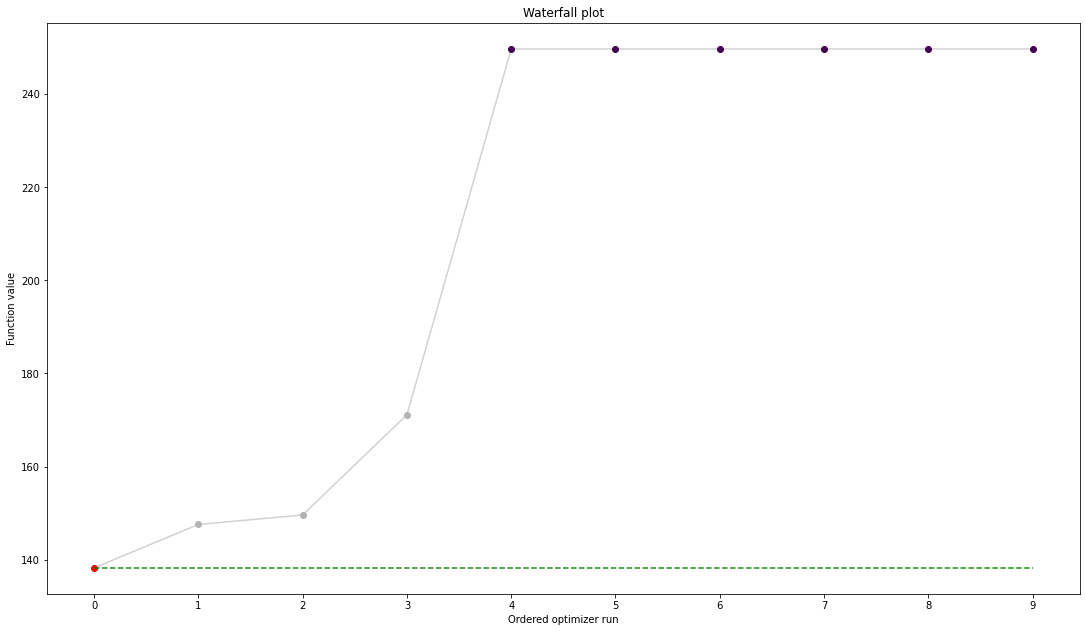

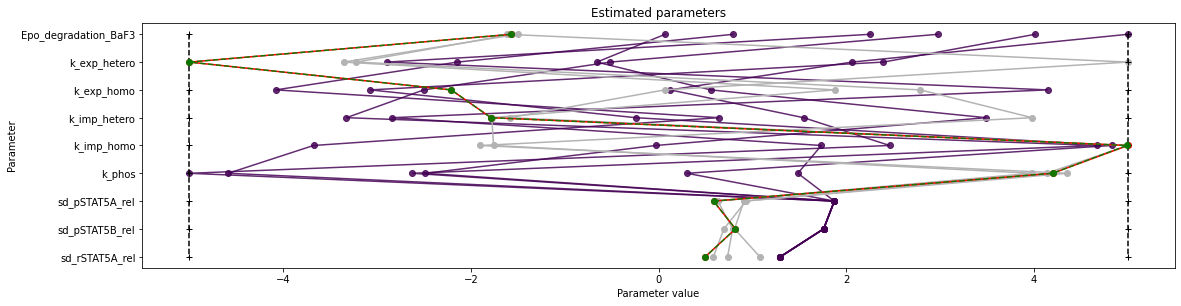

In [13]:
ref = visualize.create_references(
    x=petab_problem.x_nominal_scaled, fval=obj(petab_problem.x_nominal_scaled))

visualize.waterfall(result, reference=ref, scale_y='lin')
visualize.parameters(result, reference=ref)

We can also conveniently visualize the model fit. This plots the petab visualization
using the optimized parameters.

2021-09-24 17:29:12.989 - amici.petab_import - INFO - Successfully loaded model Boehm_JProteomeRes2014 from /Users/pauljonasjost/Documents/GitHub_Folders/pyPESTO/doc/example/amici_models/Boehm_JProteomeRes2014.


{'plot1': <AxesSubplot:title={'center':'pSTAT5A_rel'}, xlabel='Time [min]', ylabel='frac. [%]'>,
 'plot2': <AxesSubplot:title={'center':'pSTAT5B_rel'}, xlabel='Time [min]', ylabel='frac. [%]'>,
 'plot3': <AxesSubplot:title={'center':'rSTAT5A_rel'}, xlabel='Time [min]', ylabel='relative STAT5A abundance [%]'>}

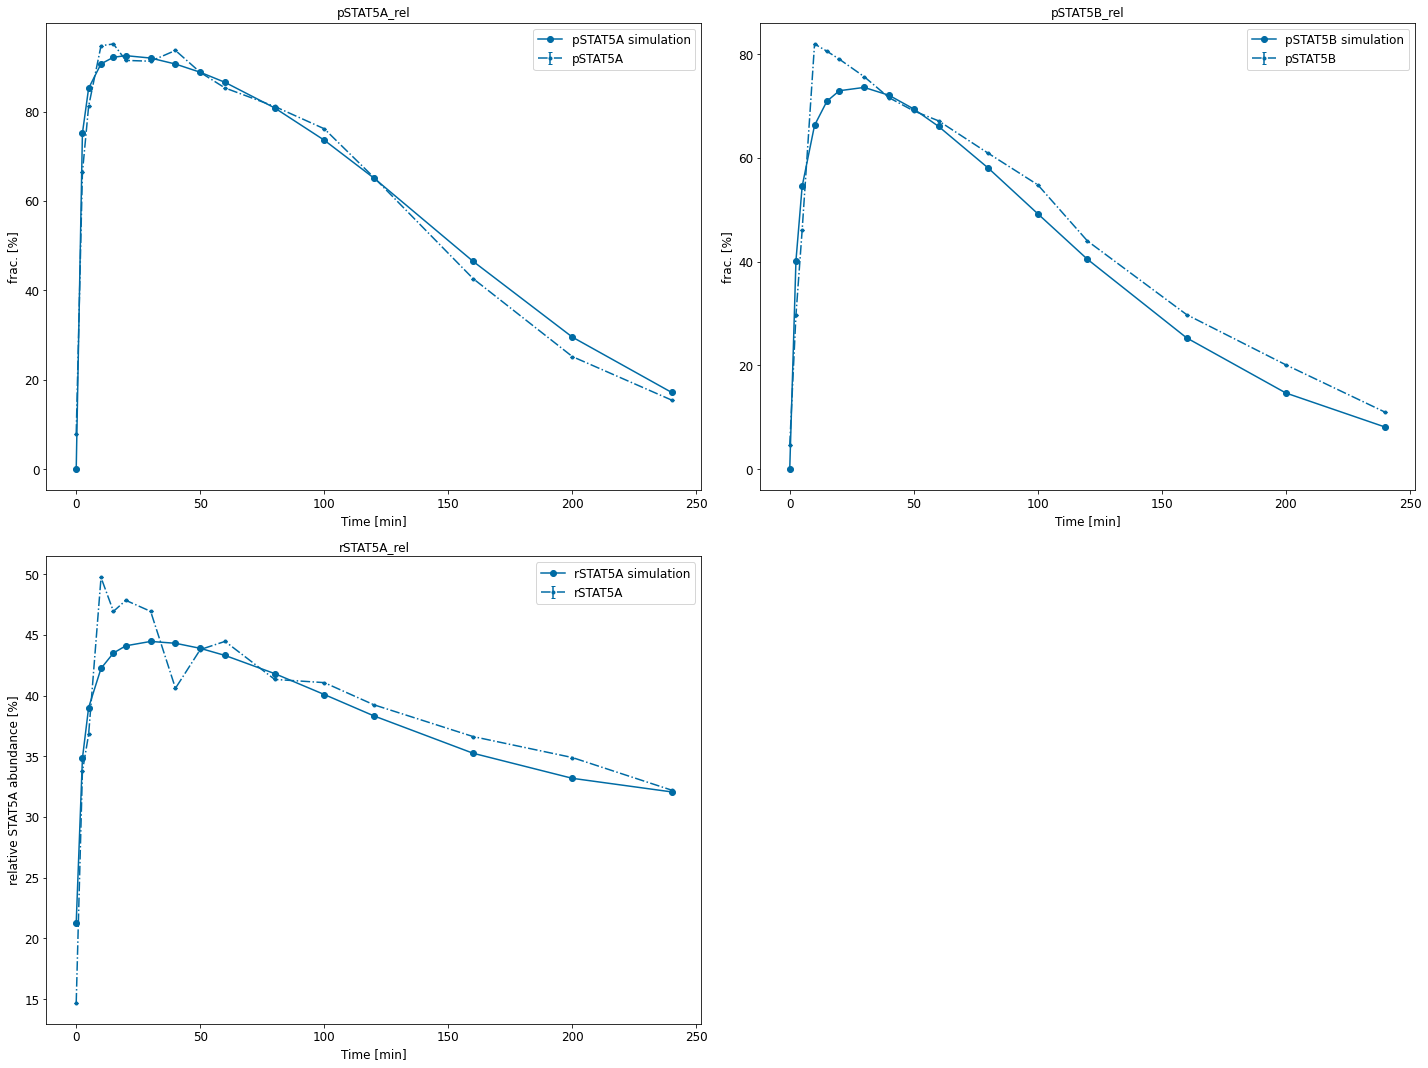

In [14]:
visualize.visualize_optimized_model_fit(petab_problem=petab_problem,
                                        result=result)